# Introduction


A typical dataset used in computer vision and deep learning is the MNIST handwritten digit classification issue.

Despite the fact that the dataset is effectively solved,In this example we will create a  test harness for estimating the model's performance, investigate model enhancements, and save and load the model to make predictions on new data.

## Loading dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


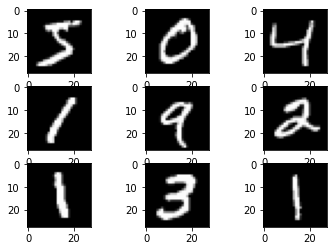

In [1]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))
# Visualise Dataset
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show()

## Making base model

Creating a baseline model is important as it will give us a point of compariosn for the improvements we make further down the line

In [2]:
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = to_categorical(trainY)
    testY = to_categorical(testY)
    return trainX, trainY, testX, testY

In [3]:
def prep_pixels(train, test):
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [4]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

We must evaluate the model after it has been defined.

Five-fold cross-validation will be used to assess the model. The value of k=5 was chosen to serve as a baseline for both repeated evaluation and to avoid requiring a long run time. Each test set will be 20% of the training dataset, or approximately 12,000 samples, which is similar to the size of the real test set for this problem.

The training dataset is shuffled before being split, and the sample shuffling is done each time, ensuring that each model we evaluate has the same train and test datasets in each fold, allowing us to compare models apples to apples.


With a default batch size of 32 examples, we'll train the baseline model for a modest 10 training epochs. The test set for each fold will be used to evaluate the model throughout each epoch of the training run so that learning curves can be created afterwards, as well as at the end of the run to estimate the model's performance. As a result, we'll maintain track of the history generated by each run, as well as the fold's categorization accuracy.

These behaviours are implemented in the evaluate model() function, which takes the training dataset as an argument and returns a collection of accuracy scores and training histories that may be summarised afterwards.

Model architecture

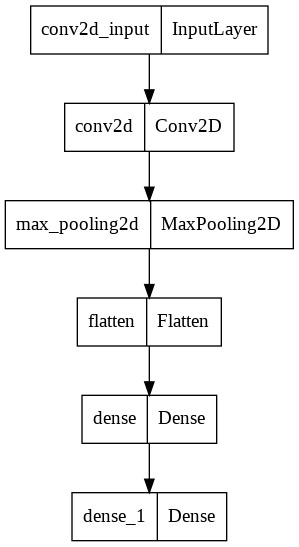

In [5]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [6]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()
 
# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


### Calling all fuunctions

In [7]:
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)


> 98.758
> 98.517
> 98.608
> 98.900
> 98.717


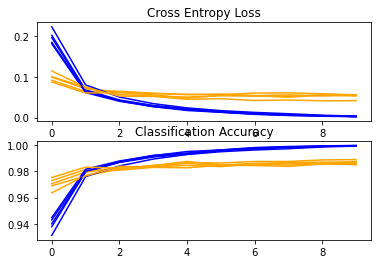

Accuracy: mean=98.700 std=0.131, n=5


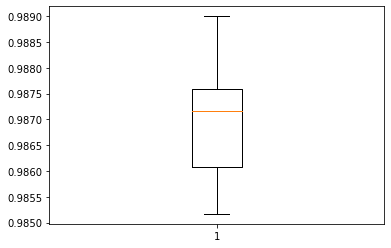

In [8]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization

run_test_harness()

As we can see this model is very consistent with it results in all of  the 5 fold of kfor validation.

We can see that the model generally achieves a good fit, with train and test learning curves converging. There is no obvious sign of over- or underfitting.

## Improved model

To develop improved model we increase the depth of the feature extraction part of the model we even increased the epochs in training for better rresults

In [9]:
def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

Updated Model Architecture



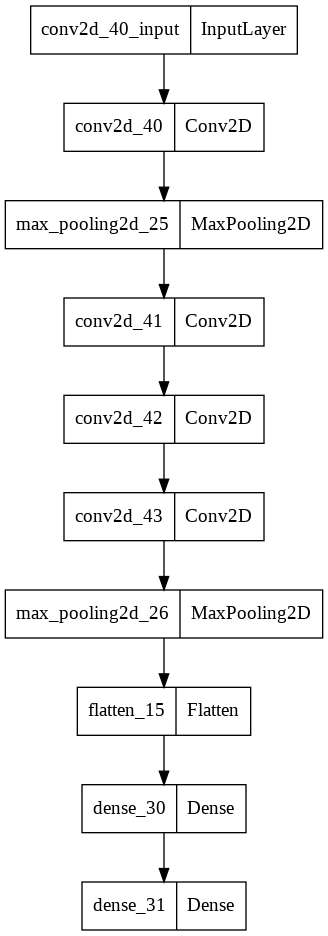

In [10]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=12, batch_size=32, validation_data=(testX, testY), verbose=0)
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose=0)
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [11]:
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)


### Running and evaluating Improved model

> 98.883
> 99.008
> 98.817
> 99.158
> 99.075


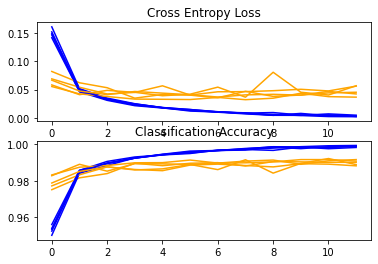

Accuracy: mean=98.988 std=0.124, n=5


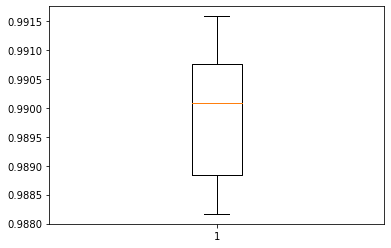

In [12]:
run_test_harness()

The plot of the learning curves is showing that the models still have a good fit on the problem, with no clear signs of overfitting. The plots may even suggest that further training epochs could be helpful.

We can wee that the avg model accuracy has shot up to 99 % and without much standard deviation  between the 5 fold runs , which shows the model performance is stable
we can see that our model perfomance has improved and now we can save the new upldated model

### Saving final model

In [13]:
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
# define model
model = define_model()
# fit model
model.fit(trainX, trainY, epochs=15, batch_size=32, verbose=0)
# save model
model.save('final_model.h5')

## loading saved model and making prediction


running the model in completely new images out of dataset



**7**
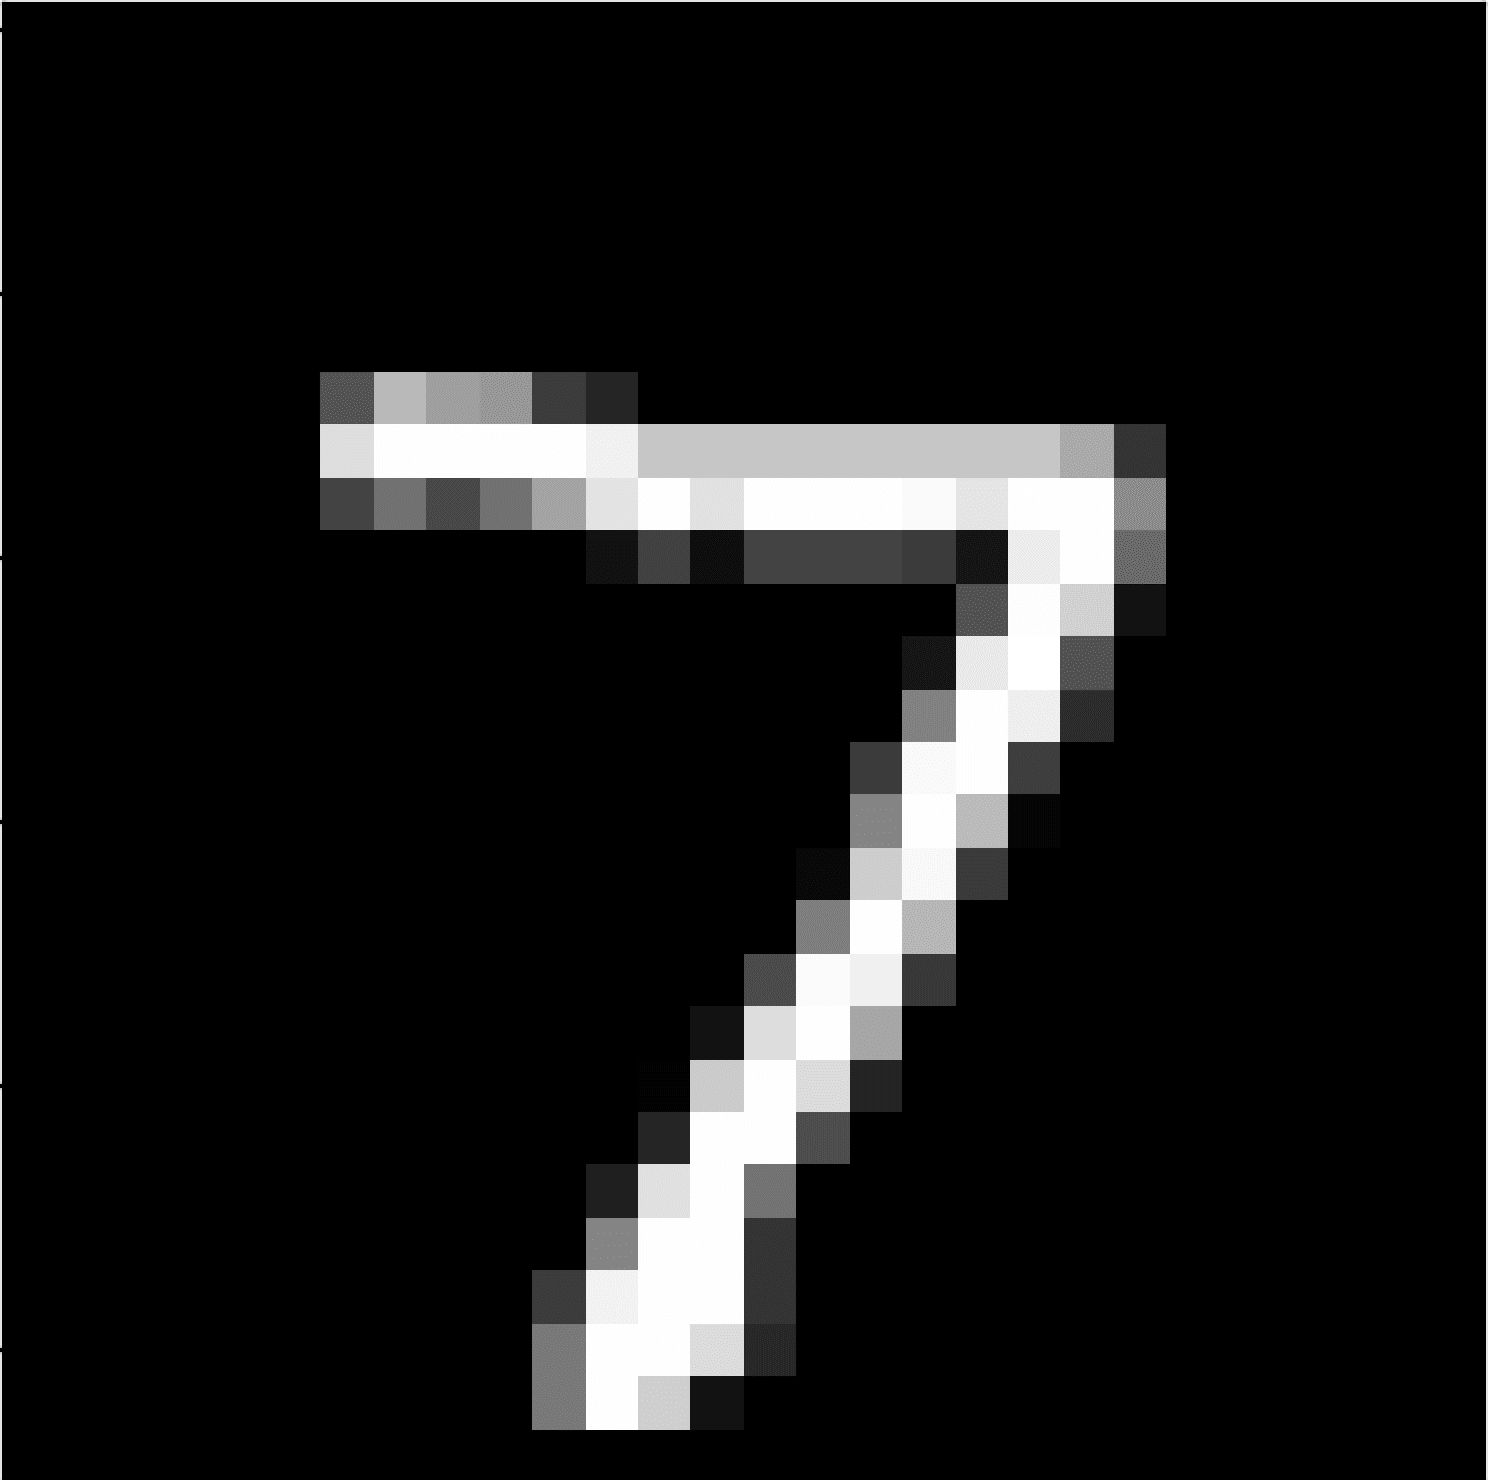

In [14]:

from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model

def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img


# load the image
img = load_image('1.png')
# load model
model = load_model('final_model.h5')
# predict the class
predict_value = model.predict(img)
digit = argmax(predict_value)
print(digit)



7


C:\Users\shikh\anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


**6**
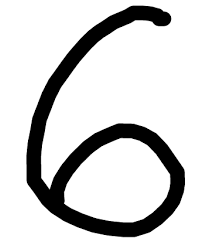

In [15]:

# load the image
img = load_image('6.png')
# load model
model = load_model('final_model.h5')
# predict the class
predict_value = model.predict(img)
digit = argmax(predict_value)
print(digit)



8


We can see that the model performs well even on images outside the dataset hence we can say that our final model is working well

#### Github link to the Repositry :- https://github.com/Shikhar10000/MNIST-Handwritten-Digit-Classification